# Forecasting Tree Trim Opened Requests

Use time series forecasting to predict the expected number of opened requests in Chicago's 311 system for parkway tree trims requested by city residents between November 2018 - October 2019.

**Project Notebooks Execution Order**
* [1-data-wrangling-optimize-verify.ipynb](1-data-wrangling-optimize-verify.ipynb)
* [2-data-wrangling-deduplicate.ipynb](2-data-wrangling-deduplicate.ipynb)
* [3-exploratory-data-analysis.ipynb](3-exploratory-data-analysis.ipynb)
* 4-forecasting-opened-requests.ipynb
* [5-forecasting-closed-requests.ipynb](4-forecasting-closed-requests.ipynb)
* [6-summary.ipynb](6-summary.ipynb)

For a full explanation of this project, see the `README.md` file at the project root or the `6-summary.ipynb` notebook.

# Import Packages and Modules

In [1]:
from itertools import product
import os
import warnings

from cycler import cycler
from IPython.core.interactiveshell import InteractiveShell
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pandas.plotting as pdplt
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm

# Settings

Configure settings for notebook, plots, files and environmental variables. Set `ast_node_interactivity` to display the output of all expressions in a cell so that more than one data frame can be printed at a time in a single cell. Semicolons at the end of `plt.show();` are used in this notebook to suppress the printing of matplotlib objects in cell outputs. Load functions called in notebook.

In [2]:
# Notebook settings
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
register_matplotlib_converters()
warnings.filterwarnings("ignore")  # matplotlib warnings

# Plot settings
alpha_mpl = 0.75
color_cycle = ['dodgerblue', '#d5019a', 'midnightblue', 'gray']
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle)
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 11

# File settings
data_raw = os.path.abspath('./data/raw/')
data_interim = os.path.abspath('./data/interim/')
data_processed = os.path.abspath('./data/processed/')
dir_figures = os.path.abspath('./figures/')

# Import preprocessing and forecasting functions
%run preprocess_data.py
%run forecast.py

# Load Data

In [3]:
df_tt = read_data(
    'Chicago Tree Trims',
    data_processed,
    'chicago-tree-trims.pkl'
)

Chicago Tree Trims
<class 'pandas.core.frame.DataFrame'>
Int64Index: 295577 entries, 118 to 360482
Data columns (total 13 columns):
creation_date_dt           295577 non-null datetime64[ns]
completion_date_dt         287211 non-null datetime64[ns]
status                     295577 non-null category
service_request_number     295577 non-null object
type_of_service_request    295577 non-null category
location_of_trees          181848 non-null category
street_address             295577 non-null object
zip_code                   295577 non-null int64
community_area             295577 non-null int64
latitude                   295485 non-null float64
longitude                  295485 non-null float64
location                   295485 non-null object
is_duplicate               295577 non-null bool
dtypes: bool(1), category(3), datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 83.0 MB
None




Split the data frame into training and test sets. Given the limited number of samples in the dataset, assign twelve months of samples to the test sets. Twelve months is not 20% of the total dataset, which is a reasonable amount for a test set, but it does equal the maximum forecast horizon for this analysis and it contains a full season of data. Also, create training and test sets from the dataset where the Service Request Numbers (SRN) duplicates are removed. The the results of the models with duplicates will be compared to the results of models without duplicates.

In [4]:
df_o_train_has_dupe, df_o_test_has_dupe = split_train_test(
    df_tt,
    'creation_date_dt',
    no_dupe=False,
)
df_o_train_no_dupe, df_o_test_no_dupe = split_train_test(
    df_tt,
    'creation_date_dt',
    no_dupe=True,
)

# Autocorrelation

In a time series context, autocorrelation measures the strength of a linear relationship between lagged values, i.e. an observation and the previous observation at a specific interval.

Plot observations against a single previous time step to visualize the autocorrelation present in the data. Observations at a previous time step are useful for predicting the value at the next time step.

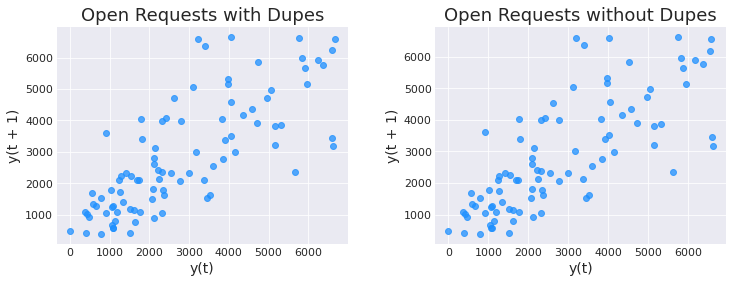

In [5]:
dfs = [
    [df_o_train_has_dupe, 'Open Requests with Dupes'],
    [df_o_train_no_dupe, 'Open Requests without Dupes'],
]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for df, ax in zip(dfs, axes.flat):
    pdplt.lag_plot(df[0]['count'], lag=1, c='C0', alpha=alpha_mpl, ax=ax)
    ax.set_xlabel('y(t)')
    ax.set_ylabel('y(t + 1)')
    ax.set_title(df[1])

plt.show();

In the opened requests plots there is a general positive linear trend with some scatter. There are no glaring differences between the plots with duplicates and without duplicates. 

Review the correlogram plots to determine potential lag values for the model. 

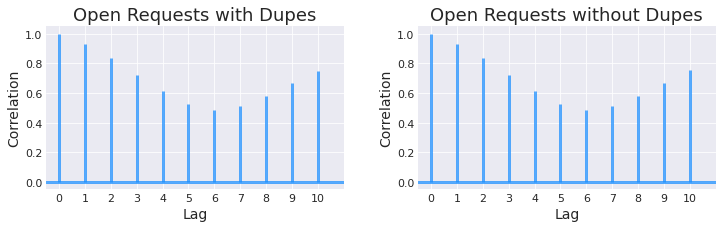

In [6]:
n_lags = 10

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
fig.subplots_adjust(hspace=0.6, wspace=0.25)

for df, ax in zip(dfs, axes.flat):

    ax.acorr(df[0]['count'].astype(float).tolist(), maxlags=n_lags,
             linewidth=3, color='C0', alpha=alpha_mpl)
    ax.set_xlim(-0.5)
    ax.set_xticks(range(n_lags+1))
    ax.set_xlabel('Lag')
    ax.set_ylabel('Correlation')
    ax.set_title(df[1])

plt.show();

The correlograms suggest the closing requests data are correlated. The graphs indicate that a possible value for lag for the dataset is **1.0**.

# Seasonal ARIMA Model

The decomposition results in the `exploratory-data-analysis.ipynb` notebook indicate that the Seasonal Autoregressive Integrated Moving Average (ARIMA) model would be appropriate for forecasting the opened requests. The Seasonal ARIMA model is a time series forecasting method that includes autoregressive terms, differencing operations, moving average terms and a seasonal component. The autoregressive term indicate the number of previous observations used to predict the next value. The differencing term converts a non-stationary time series to stationary, meaning the trend and seasonality of the data does not impact the value of a time series at a specific time. The moving average component uses past forecast errors to predict the next value. The seasonal component backshifts the data by a specified amount, such as 12 for yearly seasonality.

## Parameter Selection

Utilize grid search to find the optimal parameters for the seasonal ARIMA models. The parameters are as follows:

* p = non-seasonal autoregressive term
* d = non-seasonal differencing
* q = non-seasonal moving average term
* P = seasonal autoregressive term
* D = seasonal differencing
* Q = seasonal moving average term
* S = time span of repeating seasonal pattern

There are too few observations in this dataset to set the lag value to more than 1 in the grid search. If the maximum value for `p` is set to more than 1, the model returns an error.

In [7]:
p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

**Note:** It takes less than one minute for the opened requests grid searches below to run on a single 3.8 GHz Intel Core i5 processor.

In [8]:
df_gs_o = gs_sarima(df_o_train_has_dupe['count'], pdq, seasonal_pdq)
df_gs_o.head(5)

,pdq,seasonal_pdq,aic
0,"(1, 1, 1)","(1, 1, 1, 12)",1075.113696
1,"(1, 1, 1)","(0, 1, 1, 12)",1076.384571
2,"(0, 1, 1)","(0, 1, 1, 12)",1078.876951
3,"(0, 1, 1)","(1, 1, 1, 12)",1079.384663
4,"(1, 0, 1)","(1, 1, 1, 12)",1090.212421


Are the grid search results any different when the duplicates are excluded from the dataset?

In [9]:
df_gs_o_no_dupe = gs_sarima(df_o_train_no_dupe['count'], pdq, seasonal_pdq)
df_gs_o_no_dupe.head(5)

,pdq,seasonal_pdq,aic
0,"(1, 1, 1)","(1, 1, 1, 12)",1074.019666
1,"(1, 1, 1)","(0, 1, 1, 12)",1075.228259
2,"(0, 1, 1)","(0, 1, 1, 12)",1077.774499
3,"(0, 1, 1)","(1, 1, 1, 12)",1078.382884
4,"(1, 0, 1)","(1, 1, 1, 12)",1089.162836


The parameters are the same, regardless of whether the duplicates are included or not. However, the AIC metric, which trades off the goodness of fit vs the complexity of the model, is slightly lower for the no duplicates model. AIC is a relative measure of model fit, so use the parameters with the lowest AIC to fit the seasonal ARIMA model. 

## Fit the Model

Fit the seasonal ARIMA model for opened requests without duplicates.

In [10]:
param = df_gs_o_no_dupe.loc[0, 'pdq']
s_param = df_gs_o_no_dupe.loc[0, 'seasonal_pdq']
sarima = sm.tsa.statespace.SARIMAX(
    df_o_train_no_dupe['count'],
    order=param,
    seasonal_order=s_param,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_o = sarima.fit()
print(sarima_o.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              count   No. Observations:                   92
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -532.010
Date:                            Tue, 05 May 2020   AIC                           1074.020
Time:                                    23:30:21   BIC                           1084.892
Sample:                                03-01-2010   HQIC                          1078.309
                                     - 10-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5163      0.161      3.200      0.001       0.200       0.832
ma.L1         -0.9589      0.171   

Not all of the coefficients are significant in this model. However, the AIC for this model is the lowest of all of the models that were fit using grid search, so keep all of the coefficients in the model.

The null hypothesis of the Ljung-Box test in the time series context is the residuals are independently distributed and the alternative hypothesis is the residuals are not independently distributed, i.e. they exhibit correlation. If the associated p-value is significant, i.e. less than 0.05, the null hypothesis is rejected in favor of the alternative hypothesis. In the summary table above, the Ljung-Box p-value is not significant, indicating we should fail to reject the null hypothesis. Therefore, the residuals are independently distributed. A non-significant p-value in this context is desirable.

**Plot Diagnostics**

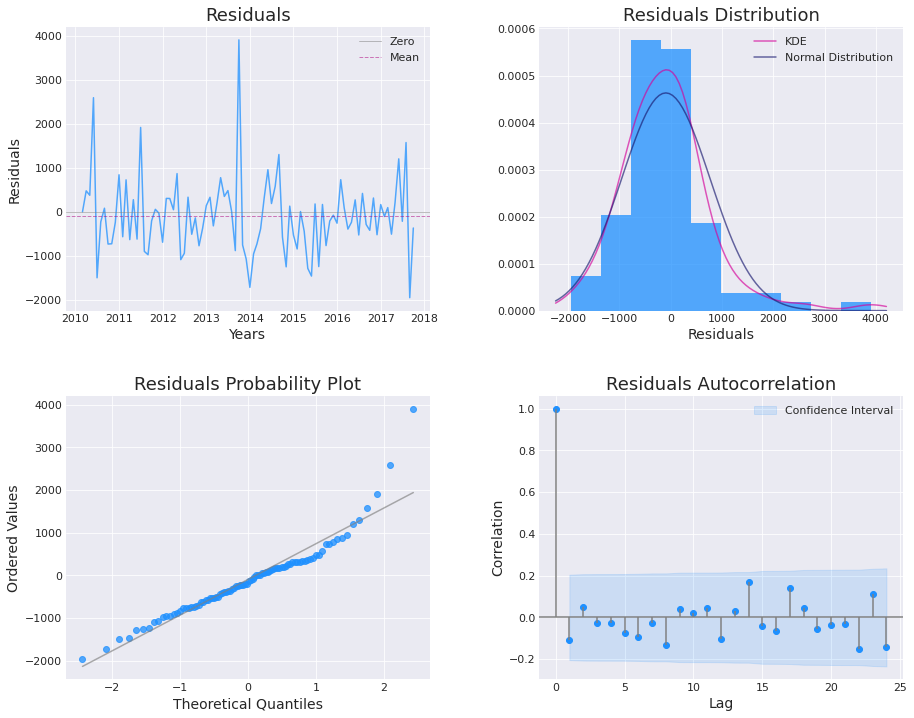

In [11]:
sarima_o_fig = sarima_diagnostics(sarima_o.resid, alpha_mpl)
plt.show();

The model residuals are random without correlation and there is no obvious seasonal or trend information in the residual plot. In the histogram plot, the Kernel Density Estimate is close but not quite normal, and the histogram skews slightly to the right. The right skew and near normality is also visible in the probability plot. The Autocorrelation plot indicates the residuals are not correlated.

## Forecast

Using the Seasonal ARIMA models fitted above, forecast the volume of opened requests for the next twelve months and then compare those results with the test set. How well do the models fit the test data? 

Compare the predicted values against observed values in the training set.

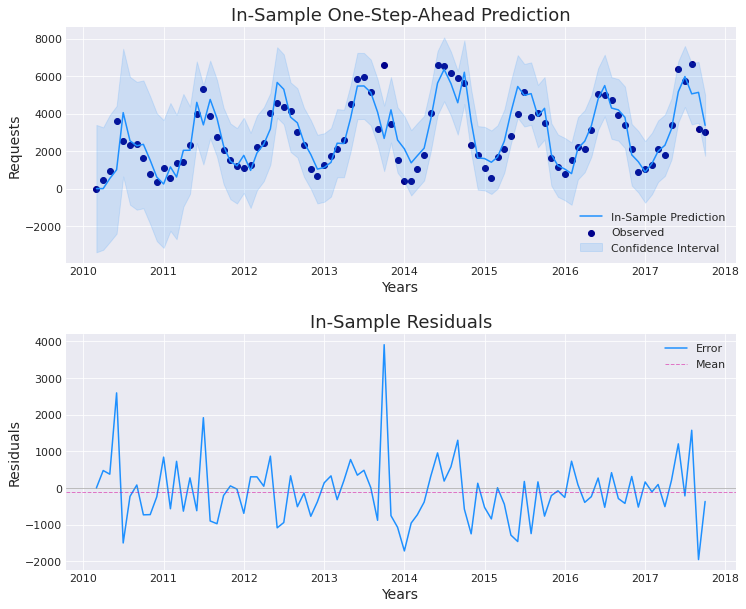

In [12]:
fcast_o_in, ci_o_in, resid_o_in = forecast_in_sample(sarima_o)

fig_o_in_sample = plot_in_sample_forecast(
    fcast_o_in, 
    ci_o_in, 
    resid_o_in, 
    df_o_train_no_dupe,
)
plt.show();

In the In-Sample plot the confidence intervals on the left side are very wide and narrow somewhat as the plot moves to the right. However, the intervals on the right are still relatively wide; a dataset with more observations would narrow the intervals. The model reflects the observed values fairly well, and all but one data point falls within the confidence intervals. That data point, which is the October 2013 outlier, sits well above the confidence interval. 

In the residuals plot the residuals are random. There is a dramatic peak in 2013, which corresponds to the October 2013 spike in opened requests.

### Model Performance

To evaluate the performance of the model, calculate both the Mean Absolute Error (MAE) and the Root Mean Squared Error (RMSE).  The RMSE is commonly used to evaluate performance on a time series model, however it is more sensitive to occasional large forecast errors, such as the October 2013 error. This is because squaring the error in RMSE heavily weights large errors. Both RMSE and MAE return results in the original units of the dataset.

In [13]:
mae_o_in, rmse_o_in, mape_o_in = eval_metrics(
    fcast_o_in, 
    df_o_train_no_dupe['count']
)

pd.DataFrame(
    [
        ['MAE', mae_o_in], 
        ['RMSE', rmse_o_in], 
        ['MAPE', mape_o_in]],
    columns=['Metric', 'Value']
)

,Metric,Value
0,MAE,625.141490
1,RMSE,866.946846
2,MAPE,35.504705


There is no standard criteria for evaluating the MAE and RMSE results as they depend on the range of values in the dataset used to fit the model. However, lower scores are better when comparing these evaluation metrics between different models based on the same dataset. Plot the MAE and RMSE results against the range of values for opened requests. 

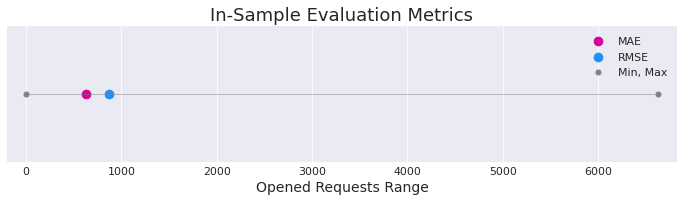

In [14]:
fig_o_in_metrics = plot_eval_metrics(
    df_o_train_no_dupe, 
    mae_o_in, 
    rmse_o_in,
    'Opened', 
    'In',
)
plt.show();

Both MAE and RMSE are low on the range of values in the opened requests data. As expected, the MAE value is lower than the RMSE value.

**Test Set Out-of-Sample Forecast**

How well do the model predictions fit the test set? Limit the plot from 2014 onwards to zoom into the forecast results.

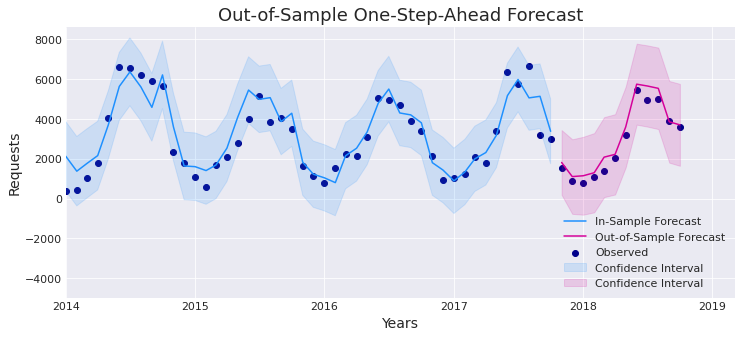

In [15]:
fcast_o_out, se_o_out, ci_o_out = forecast_out_sample(sarima_o, False)

fcast_o = (fcast_o_in, fcast_o_out, ci_o_in, ci_o_out)

fig_o_out_sample = plot_out_sample_forecast(
    df_o_train_no_dupe,
    df_o_test_no_dupe,
    False,
    fcast_o,
)
save_fig('fig_o_out_sample', dir_figures)
plt.show();

The predicted values of the test set are very close to the observed values and the predicted values follow the general seasonality of the training set. A perfect fit would indicate that the model as tuned itself too closely to the training set and therefore won't generalize well to new data. A MAE or RMSE result on the test set that is larger than the same metrics on the training set would indicate that the model is overfitting. What are the MAE and RMSE of the predictions on the test set?

In [16]:
mae_o_out, rmse_o_out, mape_o_out = eval_metrics(
    fcast_o_out, 
    df_o_test_no_dupe['count']
)

pd.DataFrame(
    [
        ['MAE', mae_o_out], 
        ['RMSE', rmse_o_out], 
        ['MAPE', mape_o_out]
    ],
    columns=['Metric', 'Value']
)

,Metric,Value
0,MAE,332.302649
1,RMSE,396.720061
2,MAPE,17.702111


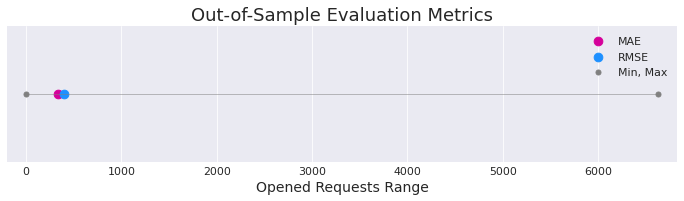

In [17]:
fig_o_out_metrics = plot_eval_metrics(
    df_o_train_no_dupe, 
    mae_o_out,
    rmse_o_out, 
    'Opened', 
    'Out-of',
)
save_fig('fig_o_out_metrics', dir_figures)
plt.show();

The MAE and RMSE scores have improved, indicating the model is not overfitting the data. 

**Test Set Forecast Errors**

In which months did the forecast produce the most extreme errors?

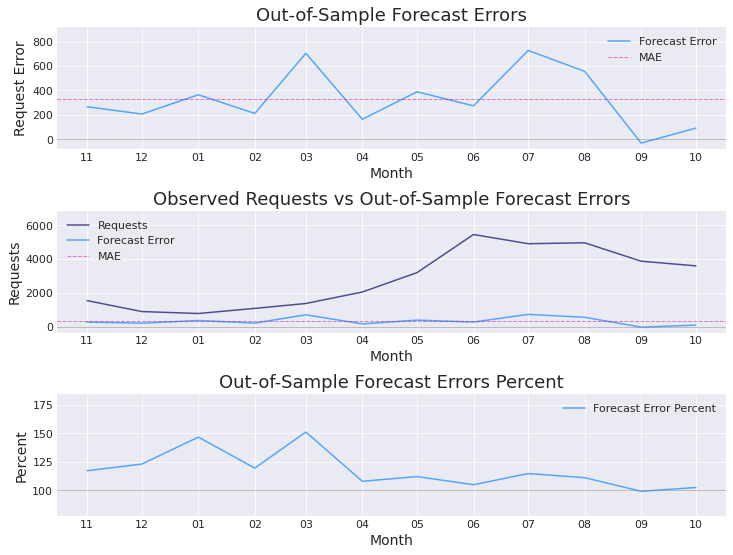

In [18]:
fig_o_err = plot_forecast_errors(
    fcast_o_out, 
    ci_o_out,
    df_o_test_no_dupe['count'], 
    alpha_mpl, 
    mae_o_out,
)
plt.show();

The months with the largest errors are March, July and August. For a majority of the months, the forecast predicted a higher volume than the actual request volume, which indicates the model has an overall positive bias. When the forecast errors are put in context of the observed volume of requests, the error rate remains relatively low compared to request volume for the late spring and summer months. However, the errors have a greater impact on the winter and early spring months given their lower volumes. The percent plot indicates that the forecast is generally over estimating the request volume, especially in November - March, which are the low volume months.

**Test Set Forecast Confidence Intervals**

The confidence intervals for the out-of-sample forecast should generally widen as the forecast horizon increases, indicating an increase in uncertainty. Plot the confidence intervals over time to verify this assumption.  

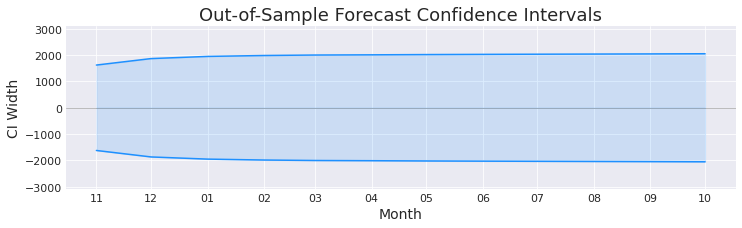

In [19]:
fig_o_ci = plot_forecast_ci(ci_o_out)
plt.show();

The forecast confidence intervals gradually widen as the forecast horizon increases, as expected.

### Twenty Four Month Forecast

What is the expected volume of opened requests from November 2018 - October 2019?

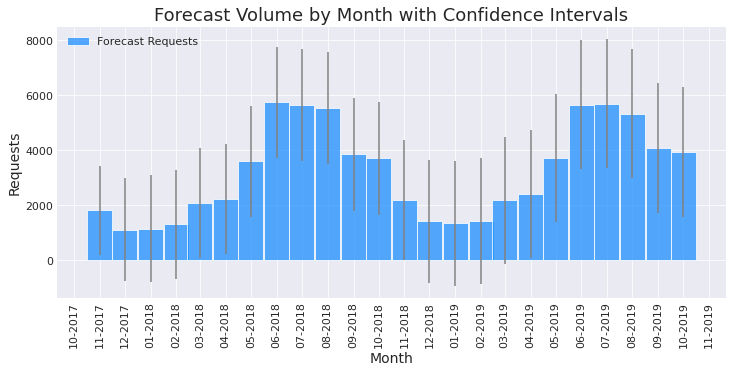

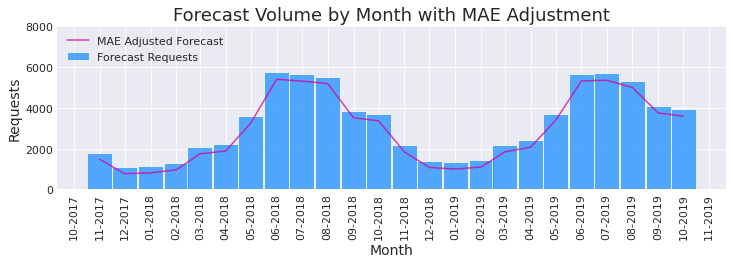

In [20]:
fig_o_vol = plot_forecast_volume(
    sarima_o, 
    df_o_test_no_dupe, 
    alpha_mpl,
    mae_o_out,
)
plt.show();

The confidence intervals are very wide given the limited size of the dataset; a larger dataset would shrink the width of the intervals. The twenty four month forecast follows the generally seasonality of the open requests dataset, with a relatively low volume in the winter and a peak in the summer. To account for the positive bias, the MAE Adjustment plot compares the unaltered forecasted values against the forecast with the MAE subtracted from each month.

# Conclusions

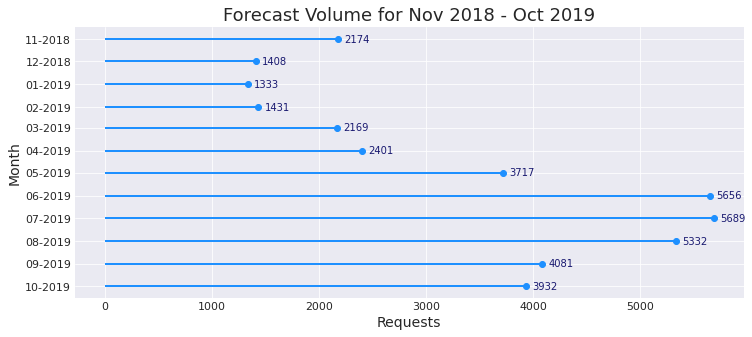

In [21]:
fig_o_fcast_values = plot_forecast_values(sarima_o, alpha_mpl)
save_fig('fig_o_fcast_values', dir_figures)
plt.show();

The forecast predicts a low of **1333** opened requests in January 2019 and a high of **5689** requests in July 2019.

Ideas for improving the model for opened requests are listed in the Next Steps section of the `summary.ipynb` notebook.